# Defining Fault Sampling Approaches in fmdtools

Fault Sampling is used to evaluate the overall resilience of a system to a set of faults and the corresponding risks associated with these faults. There is no single best way to define the set of scenarios to evaluate resilience with, because a given resilience analysis may need more or less detail, support more or less computational time, or be interested in specific scenario types of interest.

Thus, there are a number of use-cases supported by fmdtools for different sampling models. This document will demonstrate and showcase a few of them.

In [1]:
# for use in development - makes sure git version is used instead of pip-installed version
import sys, os
sys.path.insert(1,os.path.join(".."))

from fmdtools.modeldef import *
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop


### Basics

Fault sampling involves:
- Defining faults and fault models within each function/component of the model (using the `.assoc_modes()` method)
- Defining a fault sampling approach (using the `SampleApproach` class)
- Propagating faults through the model (using the `propagate.approach` method)
Before proceeding, it can be helpful to look through their respective documentation.

In [2]:
help(FxnBlock.assoc_modes)

Help on function assoc_modes in module fmdtools.modeldef:

assoc_modes(self, faultmodes={}, opermodes=[], initmode='nom', name='', probtype='rate', units='hr', exclusive=False, key_phases_by='global', longnames={})
    Associates fault and operational modes with the block when called in the function or component.
    
    Parameters
    ----------
    faultmodes : dict, optional
        Dictionary/Set of faultmodes with structure, which can have the forms:
            - set {'fault1', 'fault2', 'fault3'} (just the respective faults)
            - dict {'fault1': faultattributes, 'fault2': faultattributes}, where faultattributes is:
                - float: rate for the mode
                - dict/set/str: opportunity vector for the mode specified as a dictionary/set/string
                - list: [rate, oppvect, rcost]
                    - a list of arguments where the float arguments are specified in the order rate, rcost (if provided) and
                        an oppvect opportuni

In [3]:
help(SampleApproach)

Help on class SampleApproach in module fmdtools.modeldef:

class SampleApproach(builtins.object)
 |  SampleApproach(mdl, faults='all', phases='global', modephases={}, join_modephases=False, jointfaults={'faults': 'None'}, sampparams={}, defaultsamp={'samp': 'evenspacing', 'numpts': 1}, reduce_to=False)
 |  
 |  Class for defining the sample approach to be used for a set of faults.
 |  
 |  Attributes
 |  ----------
 |  phases : dict
 |      phases given to sample the fault modes in
 |  globalphases : dict
 |      phases defined in the model
 |  modephases : dict
 |      Dictionary of modes associated with each state
 |  mode_phase_map : dict
 |      Mapping of modes to their corresponding phases
 |  tstep : float
 |      timestep defined in the model
 |  fxnrates : dict
 |      overall failure rates for each function
 |  comprates : dict
 |      overall failure rates for each component
 |  jointmodes : list
 |      (if any) joint fault modes to be injected in the approach
 |  rates/com

In [4]:
help(prop.approach)

Help on function approach in module fmdtools.faultsim.propagate:

approach(mdl, app, staged=False, track='all', pool=False, showprogress=True, track_times='all', protect=True, run_stochastic=False, save_args={}, max_mem=2000000000.0, **kwargs)
    Injects and propagates faults in the model defined by a given sample approach
    
    Parameters
    ----------
    mdl : model
        The model to inject faults in.
    app : sampleapproach
        SampleApproach used to define the list of faults and sample time for the model.
    staged : bool, optional
        Whether to inject the fault in a copy of the nominal model at the fault time (True) or instantiate a new model for the fault (False). Setting to True roughly halves execution time. The default is False.
    track : str ('all', 'functions', 'flows', 'valparams', dict, 'none'), optional
        Which model states to track over time, which can be given as 'functions', 'flows', 
        'all', 'none', 'valparams' (model states specifie

### Model Setup

Consider the following (highly simplified) rover electrical/navigation model. We can define the functions of this rover using the classes:

In [5]:
class Move_Rover(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows, flownames={"EE":"EE_in"})
        self.assoc_modes({"mech_loss", "elec_open"})
    def behavior(self, time):
        if self.time < time:
            power = self.EE_in.v_supply * self.Control.vel *self.no_fault("elec_open")
            self.EE_in.a_supply = power/12
            if power >100: self.add_fault("elec_open")
            else:          self.Ground.x = self.Ground.x + power*self.no_fault("mech_loss")

This use of `assoc_modes` specifies that there are two modes to inject, "mech_loss", and "elec_open", with no more information given for each mode. This is a syntax one might use as one is constructing the model and wishing to verify behaviors, or where modes are only caused behaviorally due to external scenarios. (in this case an open circuit is caused by too much power supply)

In [6]:
class Control_Rover(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows)
        self.assoc_modes({'no_con':[1e-4, 200]}, ['drive','standby'], initmode='standby')
    def behavior(self,time):
        if not self.in_mode('no_con'):
            if time == 5: self.set_mode('drive')
            if time == 50: self.set_mode('standby')
        if time>self.time:
            if self.in_mode('drive'):
                self.Control.power = 1
                self.Control.vel = 1
            elif self.in_mode('standby'):
                self.Control.vel = 0
                self.Control.power=0

This use of `assoc_modes` specifies modes (`no_con`) with a rate (1e-4) and a repair cost (200), as well as a set of operational modes that the system proceeds through. Specifying operational modes enables one to define different *behaviors* for the system depending on the configuration of the system at a given time. For example, in this function, the system goes into a drive mode at t=5, which powers on the system and outputs a command to move forward. 

When operational modes are specified in the model, an initial mode must also be specified--in this case `initmode='standby'` specifies that the function starts in the standby mode.

In [11]:
class Store_Energy(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows, states={"charge": 100})
        self.assoc_modes({"no_charge":[1e-5, {'standby':1.0}, 100],"short":[1e-5, {'supply':1.0}, 100],}, ["supply","charge","standby"], initmode="standby", exclusive = True, key_phases_by='self')
    def behavior(self,time):
        if time > self.time:
            if self.in_mode("standby"):     
                self.EE.v_supply = 0; self.EE.a_supply = 0
                if self.Control.power==1: self.set_mode("supply")
            elif self.in_mode("charge"):    
                self.EE.charge =min(self.EE.charge+self.dt, 20)
            elif self.in_mode("supply"):
                if self.charge > 0:         self.EE.v_supply = 12; self.charge -= int(self.dt)
                else: self.set_mode("no_charge")
                if self.Control.power==0: self.set_mode("standby")
            elif self.in_mode("short"):     self.EE.v_supply = 100; self.charge = 0
            elif self.in_mode("no_charge"): self.EE.v_supply=0

In addition to operational modes, the Battery Function additionally specifies an *opportunity vector* which defines when each fault mode is likely to occur (and thus be injected in the model). In this case, `no_charge` can only occur during standby mode, while a `short` can only occur during the supply mode. The  `key_phases_by='self'` option specifies that these phases are *internal* to the function. Opporunity vectors can also be keyed to phases in other functions using `key_phases_by='fxnname'` and `key_phases_by='global'`. There are several ways to define this opportunity vector, which will be described later.

This model also uses the `exclusive` option, which specifies that fault modes cannot co-occur with operational modes. That is, instead of *modifying* individual mode behaviors, fault modes in this function instead cause the system to enter a new mode with different defined mode behaviors. 


In [12]:
import fmdtools.resultdisp as rd
class Rover(Model):
    def __init__(self, params={},\
                 modelparams={'times':[0,60], 'tstep':1, 'phases': {'firsthalf':[0,30], 'secondhalf':[31,60]}},\
                 valparams={}):
        super().__init__(params, modelparams, valparams)
        
        self.add_flow('Ground', {'x':0.0,'y':0.0, 'dir':0.0, 'vel':0.0})
        self.add_flow('EE', {'v_supply':0.0, 'a_supply':0.0})
        self.add_flow('Control', {'dir':0.0, 'vel':0.0, 'power':0.0})
        
        self.add_fxn("Control_Rover",["EE", "Control"], fclass=Control_Rover)
        self.add_fxn("Move_Rover", ["Ground","EE", "Control"], fclass = Move_Rover)
        self.add_fxn("Store_Energy", ["EE", "Control"], Store_Energy)
        
        self.build_model()
    def find_classification(self, scen, mdlhists):
        repcost = self.calc_repaircost()
        reshist, diff, summary = rd.process.hist(mdlhists)
        losscost = sum([bool(i) for i in reshist['stats']['total faults']])
        totcost=repcost+losscost
        return {'cost':totcost, 'rate':scen['properties']['rate'], 'expected cost':totcost*scen['properties']['rate']}

`"global"` phases in the model are defined using the 'phases' string in model parameters. Phases define distinct periods or activities of operation when the model may be in a different state (resulting in different potential failure mode effects and opportunities for failure modes to be entered).

### Setting up an approach

Because this model has an opportunity vector which is keyed by its operational modes, the history of modes needs to be generated for the model to set up the sample approach--otherwise this information cannot be used, as shown below:

In [13]:
mdl = Rover()
app = SampleApproach(mdl)

To form this history, the model is run in the nominal scenario, as shown.

In [14]:
endclass , resgraph,mdlhist = prop.nominal(mdl)
mdlhist['functions']['Store_Energy']

{'faults': array(['nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom'], dtype='<U9'),
 'charge': array([100, 100, 100, 100, 100, 100,  99,  98,  97,  96,  95,  94,  93,
         92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,  80,
         79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,  67,
         66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  55,
         55,  55,  55,  55,  55,  55,  55,  55,  55]),
 'mode': array(['standby', 'standby', 'standby', 'standby', 'standby', 'supply',
        'supply', 'supply', 'supply', 'supply', 'suppl

To get the phase information, the 'process.modephases' method is used.

In [15]:
phases, modephases = rd.process.modephases(mdlhist)

Which returns `phases`, the phases of operation for each function where operational modes were defined:

In [16]:
phases

{'Control_Rover': {'standby': [0, 4], 'drive': [5, 49], 'standby1': [50, 60]},
 'Move_Rover': {'nom': [0, 60]},
 'Store_Energy': {'standby': [0, 4], 'supply': [5, 49], 'standby1': [50, 60]}}

as well as `modephases`, which lists the phases associated with each mode.

In [17]:
modephases

{'Control_Rover': {'standby': {'standby', 'standby1'}, 'drive': {'drive'}},
 'Move_Rover': {'nom': {'nom'}},
 'Store_Energy': {'standby': {'standby', 'standby1'}, 'supply': {'supply'}}}

These phases can be visualized with `rd.plot.phases`

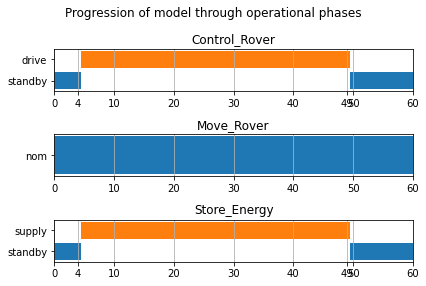

In [18]:
fig = rd.plot.phases(phases,modephases)

To correctly sample according to the fault model's intent (that each fault can occur within each `mode`), SampleApproach is given both `phases` and `modephases`, as shown below.

In [19]:
app_correct = SampleApproach(mdl, phases=phases, modephases=modephases)
app_correct.sampletimes

{('global',
  'firsthalf'): {15: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')]},
 ('global',
  'secondhalf'): {45: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')]},
 ('Store_Energy', 'standby'): {2: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'standby1'): {55: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'supply'): {27: [('Store_Energy', 'short')]}}

In [20]:
type(tuple(phases.values())[0])

dict

In [21]:
app_incorrect = SampleApproach(mdl, phases=phases)
app_incorrect.sampletimes

{('global',
  'firsthalf'): {15: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')]},
 ('global',
  'secondhalf'): {45: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')]},
 ('Store_Energy', 'standby'): {2: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'supply'): {27: [('Store_Energy', 'short')]}}

As shown, in the first sampleapproach, only the first phases of the mode are sampled, and not the second phases, because there is nothing to tell the approach which phases are associated with which mode, and the opportunity vector was keyed by modes. However, there are cases where it may not be necessary to provide `modephases` when providing , specifically:
- If the opportunity vector is defined in terms of local `phases` directly instead of `modes`, (e.g. by `{standby`:rate, `supply`:rate, `standby1`:rate}))
- If only the first phase is of interest
- If all fault modes are keyed by `global` phases

Note how different opportunity vectors lead to different sample approaches:

In [22]:
app_correct.sampletimes

{('global',
  'firsthalf'): {15: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')]},
 ('global',
  'secondhalf'): {45: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')]},
 ('Store_Energy', 'standby'): {2: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'standby1'): {55: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'supply'): {27: [('Store_Energy', 'short')]}}

- `Move_Rover`, and `Control_Rover`, where no opportunity vector was provided, are sampled once in the middle of an `operating` phase
- `Store_Energy` is sampled once in each given phase (defined itself).
- None of the modes are sampled during the global phases (although they could be, if that was provided in the function defintion)

Joint fault modes can additionally be inserted in the model. These fault modes are given their own phases for rates and injection times by finding the overlap between the operational phases of their constituent modes:

In [23]:
app_joint = SampleApproach(mdl, phases=phases, modephases=modephases, jointfaults = {'faults':2})
app_joint.sampletimes

{('global',
  'firsthalf'): {15: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')], 0: [(('Control_Rover', 'no_con'),
    ('Move_Rover', 'elec_open')),
   (('Control_Rover', 'no_con'),
    ('Move_Rover', 'mech_loss'))], 1: [(('Control_Rover',
     'no_con'), ('Move_Rover', 'elec_open')),
   (('Control_Rover', 'no_con'), ('Move_Rover', 'mech_loss'))]},
 ('global',
  'secondhalf'): {45: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'elec_open'),
   ('Move_Rover', 'mech_loss')], 32: [(('Control_Rover', 'no_con'),
    ('Move_Rover', 'elec_open')),
   (('Control_Rover', 'no_con'),
    ('Move_Rover', 'mech_loss'))], 31: [(('Control_Rover',
     'no_con'), ('Move_Rover', 'elec_open')),
   (('Control_Rover', 'no_con'), ('Move_Rover', 'mech_loss'))]},
 ('Store_Energy', 'standby'): {2: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'standby1'): {55: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'supply'): {27: [('Store_Energy', 'short')]},

### Propagating Faults

Given the fault sampling approach, the faults can then be propagated through the model to get results. Note that these faults can be sampled in parallel if desired using a user-provided pool (see the parallel pool tutorial in the `\pump example` folder).

In [24]:
endclasses, mdlhists = prop.approach(mdl, app_correct)

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 150.01it/s]


In [25]:
endclasses

{'Control_Rover no_con, t=15': {'cost': 246.0,
  'rate': 0.0015500000000000002,
  'expected cost': 0.38130000000000003},
 'Move_Rover elec_open, t=15': {'cost': 46.0,
  'rate': 7.75,
  'expected cost': 356.5},
 'Move_Rover mech_loss, t=15': {'cost': 46.0,
  'rate': 7.75,
  'expected cost': 356.5},
 'Control_Rover no_con, t=45': {'cost': 216.0,
  'rate': 0.0015,
  'expected cost': 0.324},
 'Move_Rover elec_open, t=45': {'cost': 16.0,
  'rate': 7.5,
  'expected cost': 120.0},
 'Move_Rover mech_loss, t=45': {'cost': 16.0,
  'rate': 7.5,
  'expected cost': 120.0},
 'Store_Energy no_charge, t=2': {'cost': 159.0,
  'rate': 2.5e-05,
  'expected cost': 0.003975},
 'Store_Energy no_charge, t=55': {'cost': 106.0,
  'rate': 5.5e-05,
  'expected cost': 0.00583},
 'Store_Energy short, t=27': {'cost': 134.0,
  'rate': 0.00045000000000000004,
  'expected cost': 0.060300000000000006},
 'nominal': {'cost': 0.0, 'rate': 1.0, 'expected cost': 0.0}}

Note that the results here reflect the lack of information given for rates in the `Control_Rover` and `Move_Rover` functions (which default to a value of 1) and the rates do not correspond *direct* to the given rates because rates shown here are per-run rates which are spread over the model. Additionally, all scenarios default to a cost of 1 because of the lack of a classification function.

These responses can be visualized:

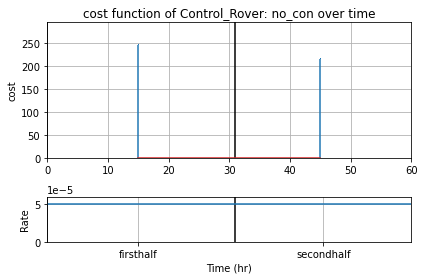

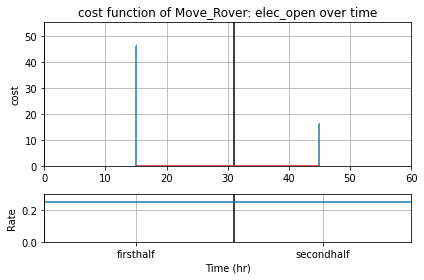

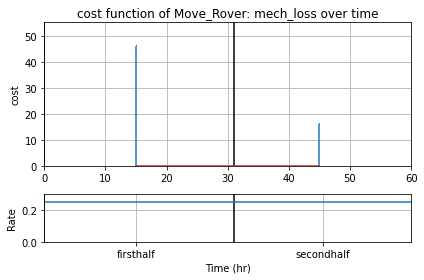

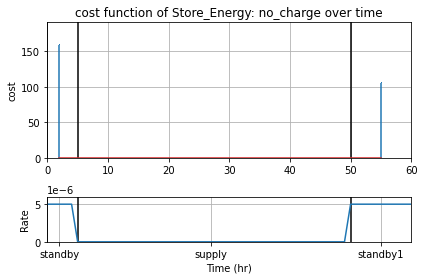

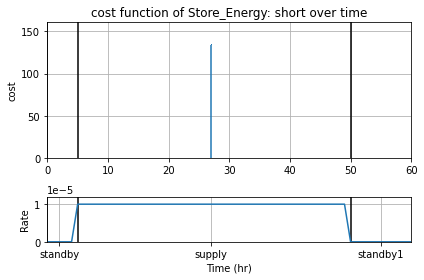

In [26]:
rd.plot.samplemetrics(app_correct, endclasses)

## Time Sampling Options
Above shows the default time-sampling option--a single fault sample in the middle of the operational phase. However, this approach can be varied to include multiple points for a more accurate sample. This is varied using the options:
- defaultsamp (a dict), which specifies the default sampling approach for all faults/phases
- sampparams  (a dict), which specifies the sampling approach for individual faults/phases not included in the default

For example, in the following approach, we specify that each phase is represented by three evenly-spaced points

In [27]:
app_three = SampleApproach(mdl, phases=phases, modephases=modephases, defaultsamp={'samp':'evenspacing', 'numpts':3})

In [28]:
app_three.times

[1, 2, 3, 8, 15, 16, 22, 27, 38, 45, 52, 53, 55, 58]

In [29]:
endclasses_three, mdlhists_three = prop.approach(mdl, app_three)

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 172.22it/s]


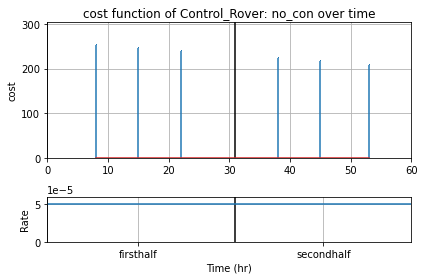

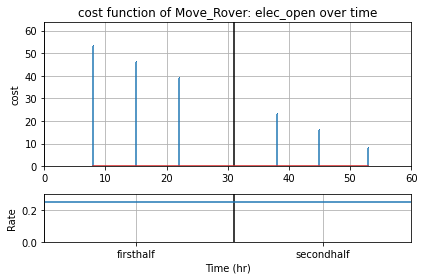

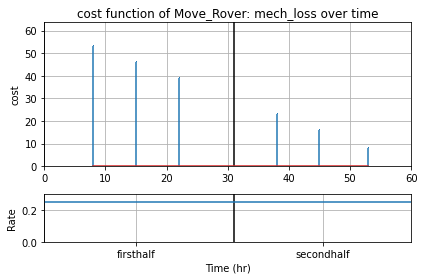

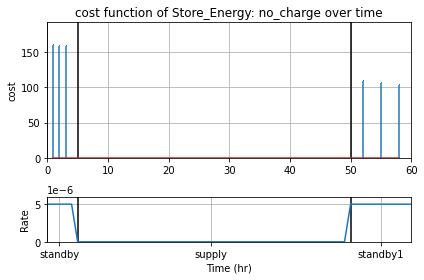

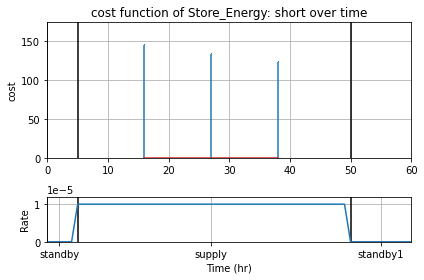

In [30]:
rd.plot.samplemetrics(app_three, endclasses_three)

We can also supply a quadrature externally by specifying a dictionary with node and weight positions. These can come from an external quadrature generator (e.g., quadpy, scipy).

In [31]:
from scipy import integrate
nodes, weights = integrate._quadrature._cached_roots_legendre(3)

In [32]:
nodes

array([-0.77459667,  0.        ,  0.77459667])

In [33]:
weights

array([0.55555556, 0.88888889, 0.55555556])

In [34]:
app_quad = SampleApproach(mdl, phases=phases, modephases=modephases, defaultsamp={'samp':'quadrature', 'quad': {'nodes':nodes,'weights':weights}})
endclasses_quad, mdlhists_quad = prop.approach(mdl, app_quad)

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 136.71it/s]


In [35]:
app_quad.times

[0, 2, 3, 4, 10, 15, 27, 34, 44, 45, 51, 55, 57, 59]

As shown, while the times are *similar* to an evenly-spaced quadrature, they are not quite the same. Additionally, the weights of the quadrature mean that some points matter more when calculating the overall sum of sample costs. This can be visualized below:

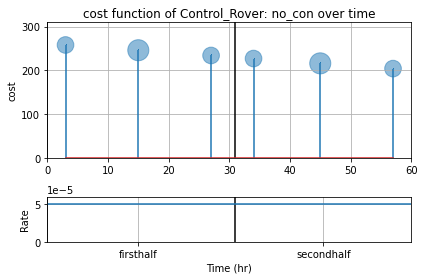

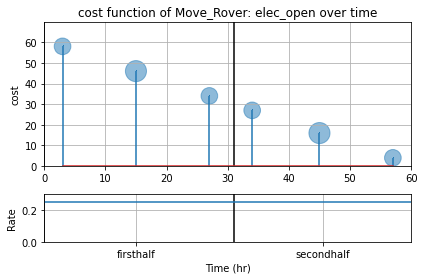

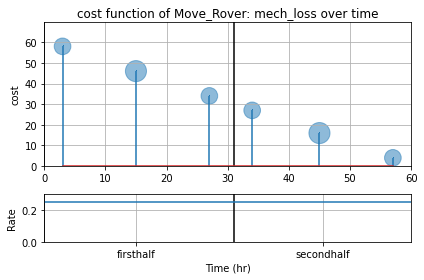

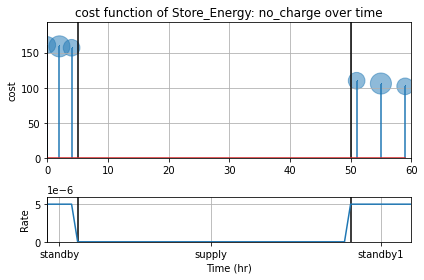

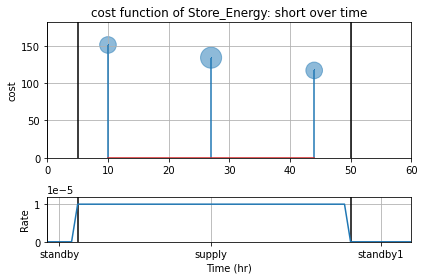

In [36]:
rd.plot.samplemetrics(app_quad, endclasses_quad)

We can also sample every time--this is costly (often prohibitively). However, one has more assurance with a full approach that the overall integration will be accurate, an important consideration when the resilience loss function is nonlinear (e.g., systems where there are delays or step-changes in the faulty behavior)

In [37]:
app_full = SampleApproach(mdl, phases=phases, modephases=modephases, defaultsamp={'samp':'fullint'})
endclasses_full, mdlhists_full = prop.approach(mdl, app_full)

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████| 244/244 [00:01<00:00, 175.23it/s]


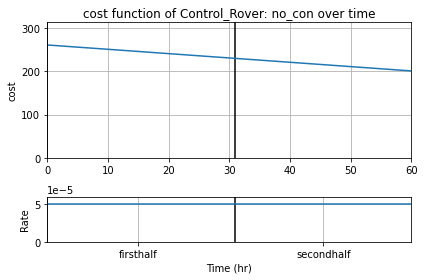

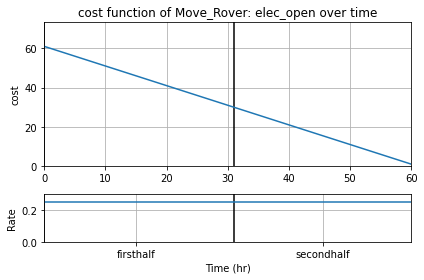

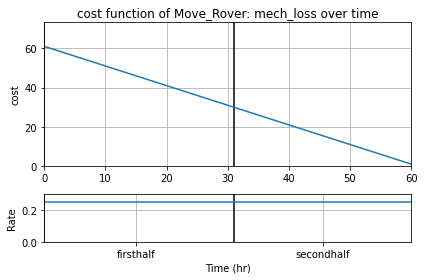

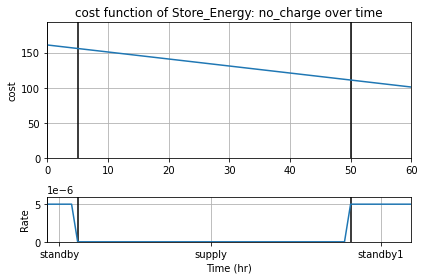

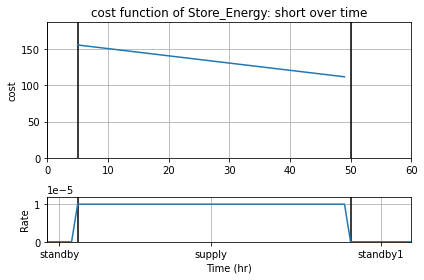

In [38]:
rd.plot.samplemetrics(app_full, endclasses_full)

As shown, the cost function is effectively linear over time. This is expected, since the costs we put in `find_classification` are based on the amount of time the fault is present in the simulation.

### Pruning

SampleApproach pruning can be used to reduce the number of points used to represent the overall costs. A pruned approach could then be used to re-run the set of faults at reduced computational costs, provided the time-based behavior has not changed significantly. This is performed using the SampleApproach.prune_scenarios method.

In [39]:
help(app_full.prune_scenarios)

Help on method prune_scenarios in module fmdtools.modeldef:

prune_scenarios(endclasses, samptype='piecewise', threshold=0.1, sampparam={'samp': 'evenspacing', 'numpts': 1}) method of fmdtools.modeldef.SampleApproach instance
    Finds the best sample approach to approximate the full integral (given the approach was the full integral).
    
    Parameters
    ----------
    endclasses : dict
        dict of results (cost, rate, expected cost) for the model run indexed by scenid 
    samptype : str ('piecewise' or 'bestpt'), optional
        Method to use. 
        If 'bestpt', finds the point in the interval that gives the average cost. 
        If 'piecewise', attempts to split the inverval into sub-intervals of continuity
        The default is 'piecewise'.
    threshold : float, optional
        If 'piecewise,' the threshold for detecting a discontinuity based on deviation from linearity. The default is 0.1.
    sampparam : float, optional
        If 'piecewise,' the sampparam sampp

In [40]:
app_full.prune_scenarios(endclasses_full)

In [41]:
app_full.times

[2, 14, 27, 45, 54]

In [42]:
endclasses_pruned, mdlhists_pruned = prop.approach(mdl, app_full)

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 136.68it/s]


As shown, with the default options the pruned sampling approach applies a centered single-point, as would happen using the default options. This would change if there were nonlinearities in the resilience loss function.

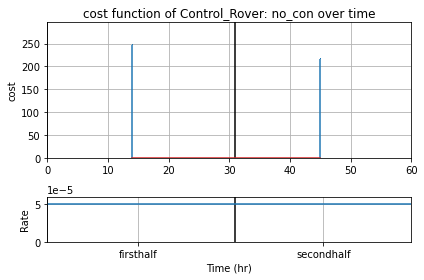

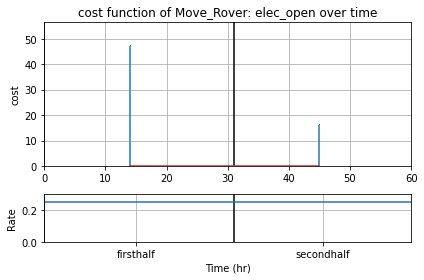

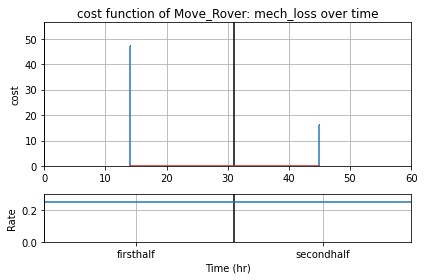

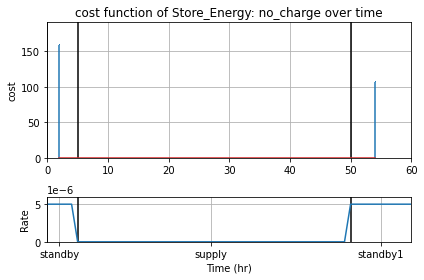

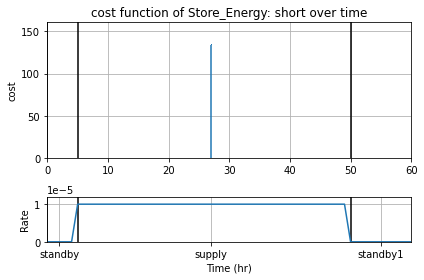

In [43]:
rd.plot.samplemetrics(app_full, endclasses_pruned)

A more detailed investigation of sampling approaches is provided in `/example_pump/IDETC_Results/IDETC_Figures.ipynb` and its corresponding paper:

*Hulse, D., Hoyle, C., Tumer, I. Y., Goebel, K., & Kulkarni, C. (2020, August). Temporal Fault Injection Considerations in Resilience Quantification. In International Design Engineering Technical Conferences and Computers and Information in Engineering Conference (Vol. 84003, p. V11AT11A040). American Society of Mechanical Engineers.*